In [1]:
import json
import pandas as pd
from tqdm import tqdm
from prettytable import PrettyTable

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit import RDLogger

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional, Union, Tuple

RDLogger.DisableLog('rdApp.*')

# Code

In [2]:
template_codes = [f'<RX_{i+1}>' for i in range(10)]

template_names = [
    'Heteroatom alkylation and arylation',
    'Acylation and related processes',
    'C-C bond formation',
    'Heterocycle formation',
    'Protections',
    'Deprotections',
    'Reductions',
    'Oxidations',
    'Functional group conversions (FGI)',
    'Functional group additions (FGA)'
]

In [3]:
def smi2validmol(smi: str) -> Optional[Chem.Mol]:
    '''
    converts a SMILES string to a valid RDKit molecule
    smi: SMILES string
    returns: RDKit molecule
    '''
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    try:
        Chem.SanitizeMol(mol)
    except ValueError:
        return None
    return mol

def concat_molecules(mol_list: list) -> Optional[Chem.Mol]:
    '''
    concatenates a list of molecules into a single molecule
    mol_list: list of molecules
    returns: concatenated molecule
    '''
    try:
        concat_mol = Chem.MolFromSmiles('.'.join([Chem.MolToSmiles(mol) for mol in mol_list]))
        return concat_mol
    except:
        return None
    
def filter_small_mols(mol_list: list[Chem.Mol], min_atoms: int=3) -> list[Chem.Mol]:
    '''
    filters a list of molecules by minumim number of atoms
    mol_list: list of molecules
    min_atoms: minimum number of atoms
    returns: filtered list of molecules
    '''
    filtered_mols = []
    for mol in mol_list:
        if mol.GetNumAtoms() >= min_atoms:
            filtered_mols.append(mol)
    return filtered_mols
    
def compute_accuracy(target: list[str], predicted: list[str], min_atoms: int=-1) -> Tuple[float, float, float, list[str]]:
    '''
    finds the accuracy of a list of predicted SMILES strings
    target: list of target SMILES strings
    predicted: list of predicted SMILES strings
    min_atoms: minimum number of atoms in a molecule
    returns: accuracy, partial accuracy, list of correct SMILES strings
    '''
    target_mols = [smi2validmol(smi) for smi in target]
    predicted_mols = [smi2validmol(smi) for smi in predicted]
    
    invalid_mols = sum([1 for mol in predicted_mols if mol is None])
    penalizing_factor = 1 - (invalid_mols/len(predicted_mols)) if len(predicted_mols) > 0 else 0
    
    # Remove None values
    target_mols = [mol for mol in target_mols if mol is not None]
    predicted_mols = [mol for mol in predicted_mols if mol is not None]

    # filter small molecules
    target_mols = filter_small_mols(target_mols, min_atoms=min_atoms) if min_atoms > 0 else target_mols
    predicted_mols = filter_small_mols(predicted_mols, min_atoms=min_atoms) if min_atoms > 0 else predicted_mols

    # ensure that there are molecules in both lists
    if len(target_mols) == 0 or len(predicted_mols) == 0:
        return 0, 0, 0, []

    interesting_molecules = []
    correct = 0
    adjusted_correct = 0
    for p_mol in predicted_mols:
        for t_mol in target_mols:
            p_smi = Chem.CanonSmiles(Chem.MolToSmiles(p_mol))
            t_smi = Chem.CanonSmiles(Chem.MolToSmiles(t_mol))
            if t_mol.HasSubstructMatch(p_mol) and p_mol.HasSubstructMatch(t_mol):
                if p_smi == t_smi:
                    correct += 1
                else:
                    interesting_molecules.append((t_smi, p_smi))
                adjusted_correct += 1
    accuracy = float(correct == len(target_mols) and len(target_mols) == len(predicted_mols))
    adjusted_accuracy = float(adjusted_correct == len(target_mols) and len(target_mols) == len(predicted_mols))
    partial_accuracy = adjusted_correct/len(target_mols)
    
    return accuracy*penalizing_factor, adjusted_accuracy*penalizing_factor, partial_accuracy*penalizing_factor, interesting_molecules
    return accuracy, adjusted_accuracy, partial_accuracy, interesting_molecules

def halogen_correction(target: list[str], predicted: list[str], min_atoms: int=-1) -> Tuple[float, float, float, list[str]]:
    '''
    replaces all halogens in the target and predicted SMILES strings with iodine and computes the accuracy
    target: list of target SMILES strings
    predicted: list of predicted SMILES strings
    min_atoms: minimum number of atoms in a molecule
    returns: accuracy, partial accuracy, list of correct SMILES strings
    '''
    halogens = ['F', 'Cl', 'Br', 'I', 'At', 'Ts']
    halogen_rep = 'I'

    for halogen in halogens:
        target = [smi.replace(halogen, halogen_rep) for smi in target]
        predicted = [smi.replace(halogen, halogen_rep) for smi in predicted]

    return compute_accuracy(target, predicted, min_atoms=min_atoms)

def compute_tanimoto(target: list[str], predicted: list[str], min_atoms: int=-1) -> float:
    '''
    computes the tanimoto similarity between the target and predicted SMILES strings
    target: list of target SMILES strings
    predicted: list of predicted SMILES strings
    min_atoms: minimum number of atoms in a molecule
    returns: tanimoto similarity
    '''
    target_mols = [smi2validmol(smi) for smi in target]
    predicted_mols = [smi2validmol(smi) for smi in predicted]
    
    # Remove None values
    target_mols = [mol for mol in target_mols if mol is not None]
    predicted_mols = [mol for mol in predicted_mols if mol is not None]

    # filter small molecules
    target_mols = filter_small_mols(target_mols, min_atoms=min_atoms) if min_atoms > 0 else target_mols
    predicted_mols = filter_small_mols(predicted_mols, min_atoms=min_atoms) if min_atoms > 0 else predicted_mols

    # concatenate molecules
    target_mol_concat = concat_molecules(target_mols)
    predicted_mol_concat = concat_molecules(predicted_mols)

    if target_mol_concat is not None and predicted_mol_concat is not None:
        t_fp = AllChem.GetMorganFingerprintAsBitVect(target_mol_concat, 3, nBits=2048)
        p_fp = AllChem.GetMorganFingerprintAsBitVect(predicted_mol_concat, 3, nBits=2048)
        return DataStructs.TanimotoSimilarity(t_fp, p_fp)
    else:
        return 0.0

In [4]:
def get_metrics(target_list: list[list[str]], predicted_list: list[list[str]], 
                apply_halogen_correction: bool=False, min_atoms: int=-1) -> Tuple[list[float], list[float], list[float], list[float], list[str]]:
    '''
    computes the accuracy, partial accuracy, and tanimoto similarity for a list of target and predicted SMILES strings
    target_list: list of target SMILES strings
    predicted_list: list of predicted SMILES strings
    apply_halogen_correction: whether to apply halogen correction
    min_atoms: minimum number of atoms in a molecule
    returns: accuracy, partial accuracy, tanimoto similarity
    '''
    accuracy_list = []
    adjusted_accuracy_list = []
    partial_accuracy_list = []
    tanimoto_list = []
    interesting_molecules = []
    for target, predicted in tqdm(zip(target_list, predicted_list), total=len(target_list), desc=f'Computing metrics with halogen correction {apply_halogen_correction}'):
        accuracy, adjusted_accuracy, partial_accuracy, i_mols = compute_accuracy(target, predicted, min_atoms) if not apply_halogen_correction else halogen_correction(target, predicted, min_atoms)
        accuracy_list.append(accuracy)
        adjusted_accuracy_list.append(adjusted_accuracy)
        partial_accuracy_list.append(partial_accuracy)
        interesting_molecules.extend(i_mols)
        tanimoto_list.append(compute_tanimoto(target, predicted, min_atoms))
    return accuracy_list, adjusted_accuracy_list, partial_accuracy_list, tanimoto_list, interesting_molecules

In [5]:
def compute_score(accuracy_list: list[float], adjusted_accuracy_list: list[float], partial_accuracy_list: list[float], tanimoto_list: list[float], 
                  weights: list[float]) -> float:
    '''
    computes the score for a list of accuracy, partial accuracy, and tanimoto similarity values
    accuracy_list: list of accuracy values
    partial_accuracy_list: list of partial accuracy values
    tanimoto_list: list of tanimoto similarity values
    weights: list of weights for the accuracy, partial accuracy, and tanimoto similarity values
    returns: weighted score
    '''

    weights = np.exp(weights)/np.sum(np.exp(weights))
    assert len(weights) == 4, 'weights must be a list of length 4'
    assert np.isclose(np.sum(weights), 1.0), 'weights must sum to 1'

    score = np.mean([accuracy_list, adjusted_accuracy_list, partial_accuracy_list, tanimoto_list], axis=1) @ weights
    return score

In [6]:
def print_scores(accuracy_list: list[float], adjusted_accuracy_list: list[float], partial_accuracy_list: list[float], tanimoto_list: list[float],
                 accuracy_list_hc: list[float], adjusted_accuracy_list_hc: list[float], partial_accuracy_list_hc: list[float], tanimoto_list_hc: list[float],
                 weights: list[float], table_name: str) -> None:
    '''
    prints the scores for a list of accuracy, partial accuracy, and tanimoto similarity values
    accuracy_list: list of accuracy values
    partial_accuracy_list: list of partial accuracy values
    tanimoto_list: list of tanimoto similarity values
    accuracy_list_hc: list of accuracy values with halogen correction
    partial_accuracy_list_hc: list of partial accuracy values with halogen correction
    tanimoto_list_hc: list of tanimoto similarity values with halogen correction
    weights: list of weights for the accuracy, partial accuracy, and tanimoto similarity values
    table_name: name of the table
    '''

    # stats over normal computation
    acc = np.mean(accuracy_list)
    a_acc = np.mean(adjusted_accuracy_list)
    p_acc = np.mean(partial_accuracy_list)
    tan = np.mean(tanimoto_list)
    
    # stats over halogen replacement
    acc_hc = np.mean(accuracy_list_hc)
    a_acc_hc = np.mean(adjusted_accuracy_list_hc)
    p_acc_hc = np.mean(partial_accuracy_list_hc)
    tan_hc = np.mean(tanimoto_list_hc)
    
    # weighted scores
    score = compute_score(accuracy_list, adjusted_accuracy_list, partial_accuracy_list, tanimoto_list, weights=weights)
    score_hc = compute_score(accuracy_list_hc, adjusted_accuracy_list_hc, partial_accuracy_list_hc, tanimoto_list_hc, weights=weights)

    # print scores using pretty table
    table = PrettyTable()
    table.title = f'Computed Metrics for {table_name}'
    table.field_names = ['Metric', 'Original', 'Halogen Correction', 'Final Index']
    table.add_row(['Accuracy', f'{acc:.3f}', f'{acc_hc:.3f}', f'{(acc_hc+acc)/2:.3f}'])
    table.add_row(['Adjusted Accuracy', f'{a_acc:.3f}', f'{a_acc_hc:.3f}', f'{(a_acc_hc+a_acc)/2:.3f}'])
    table.add_row(['Partial Accuracy', f'{p_acc:.3f}', f'{p_acc_hc:.3f}', f'{(p_acc_hc+p_acc)/2:.3f}'])
    table.add_row(['Adjusted Tanimoto', f'{tan:.3f}', f'{tan_hc:.3f}', f'{(tan_hc+tan)/2:.3f}'])
    table.add_row(['Our Score', f'{score:.3f}', f'{score_hc:.3f}', f'{(score_hc+score)/2:.3f}'])
    print(table)

In [7]:
class Metrics:
    def __init__(self, target_list: list[list[str]], predicted_list: list[list[str]],  table_name: str, weights: list[float]=[1, 1, 1, 0.5], min_atoms: int=-1):
        '''
        computes the accuracy, partial accuracy, and tanimoto similarity for a list of target and predicted SMILES strings
        target_list: list of target SMILES strings
        predicted_list: list of predicted SMILES strings
        table_name: name of the table
        weights: list of weights for the accuracy, partial accuracy, and tanimoto similarity values
        min_atoms: minimum number of atoms in a molecule
        '''
        self.target_list = target_list
        self.predicted_list = predicted_list
        self.table_name = table_name
        self.weights = weights
        self.min_atoms = min_atoms

        self.accuracy_list, self.adjusted_accuracy_list, self.partial_accuracy_list, self.tanimoto_list, self.interesting_molecules = get_metrics(target_list, predicted_list, apply_halogen_correction=False, min_atoms=min_atoms)
        self.accuracy_list_hc, self.adjusted_accuracy_list_hc, self.partial_accuracy_list_hc, self.tanimoto_list_hc, self.interesting_molecules_hc = get_metrics(target_list, predicted_list, apply_halogen_correction=True, min_atoms=min_atoms)

    def print_metrics(self, weights=None) -> None:
        '''
        prints the scores for a list of accuracy, partial accuracy, and tanimoto similarity values
        weights: list of weights for the accuracy, partial accuracy, and tanimoto similarity values
        '''
        weights = self.weights if weights is None else weights
        print_scores(self.accuracy_list, self.adjusted_accuracy_list, self.partial_accuracy_list, self.tanimoto_list,
                     self.accuracy_list_hc, self.adjusted_accuracy_list_hc, self.partial_accuracy_list_hc, self.tanimoto_list_hc,
                     weights, self.table_name)

In [8]:
def top_n_accuracy(target_list: list[list[str]], top_n_predicted_list: list[list[list[str]]], N: int=-1, min_atoms: int=-1) -> float:
    '''
    computes the top-n accuracy for a list of target and predicted SMILES strings
    target_list: list of target SMILES strings
    top_n_predicted_list: top N list of predicted SMILES strings
    min_atoms: minimum number of atoms in a molecule
    returns: top-n accuracy
    '''
    N = len(top_n_predicted_list) if N == -1 else N
    assert N <= len(top_n_predicted_list), f'N must be less than or equal to {len(top_n_predicted_list)}'
    
    top_n_accuracy_list = np.zeros(len(target_list))
    top_n_partial_accuracy_list = np.zeros(len(target_list))
    
    for predicted_list in tqdm(top_n_predicted_list[:N], desc=f'Computing top-{N} accuracy'):
        accuracy_list, partial_accuracy_list = [], []
        
        for target, predicted in zip(target_list, predicted_list):
            accuracy, partial_accuracy, _, _ = compute_accuracy(target, predicted, min_atoms)
            accuracy_list.append(accuracy)
            partial_accuracy_list.append(partial_accuracy)
        
        top_n_accuracy_list = np.maximum(top_n_accuracy_list, np.array(accuracy_list))
        top_n_partial_accuracy_list = np.maximum(top_n_partial_accuracy_list, np.array(partial_accuracy_list))

    return np.mean(top_n_accuracy_list), np.mean(top_n_partial_accuracy_list)

# Chemformer

In [15]:
df_chem = json.load(open('results/finetuned_sampled_smiles.json', 'r'))
df_chem = pd.concat([pd.DataFrame(d) for d in df_chem['data']], axis=0)

# convert concatenated SMILES strings to lists of SMILES strings
target_list_chem = df_chem['target_smiles'].apply(lambda x: x[0].split('.'))
predicted_list_chem = df_chem['sampled_molecules'].apply(lambda x: x[0].split('.'))

In [16]:
ChemMetrics = Metrics(target_list_chem, predicted_list_chem, 'Chemformer')

Computing metrics with halogen correction True: 100%|██████████| 5004/5004 [00:13<00:00, 361.09it/s]


In [17]:
ChemMetrics.print_metrics([1, 1, 1, 0.5])

+-----------------------------------------------------------------+
|                 Computed Metrics for Chemformer                 |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.507   |       0.533        |    0.520    |
| Adjusted Accuracy |  0.527   |       0.553        |    0.540    |
|  Partial Accuracy |  0.577   |       0.592        |    0.585    |
| Adjusted Tanimoto |  0.776   |       0.776        |    0.776    |
|     Our Score     |  0.577   |       0.596        |    0.587    |
+-------------------+----------+--------------------+-------------+


In [12]:
len(ChemMetrics.interesting_molecules)

109

# SynFormer Top-N

In [9]:
df_llm = pd.read_csv('results/p3_ablation_res/test_last_beam_10.csv')
df_llm = df_llm.drop(columns=['predicted_smiles'])

# convert concatenated SMILES strings to lists of SMILES strings
target_list_chem = df_llm.apply(lambda x: eval(x['target_smiles']), axis=1).tolist()
predicted_list_chem = [df_llm.apply(lambda x: eval(x[col_name]), axis=1).tolist() for col_name in df_llm.columns if 'predicted_smiles' in col_name]

In [10]:
top_n_acc, top_n_par_acc = top_n_accuracy(target_list_chem, predicted_list_chem, N=3)
print(f'Top-10 accuracy: {top_n_acc:.3f}')
print(f'Top-10 partial accuracy: {top_n_par_acc:.3f}')

Computing top-3 accuracy: 100%|██████████| 3/3 [00:21<00:00,  7.15s/it]

Top-10 accuracy: 0.589
Top-10 partial accuracy: 0.599


In [11]:
top_n_acc, top_n_par_acc = top_n_accuracy(target_list_chem, predicted_list_chem, N=5)
print(f'Top-10 accuracy: {top_n_acc:.3f}')
print(f'Top-10 partial accuracy: {top_n_par_acc:.3f}')

Computing top-5 accuracy: 100%|██████████| 5/5 [00:34<00:00,  6.89s/it]

Top-10 accuracy: 0.604
Top-10 partial accuracy: 0.615


In [12]:
top_n_acc, top_n_par_acc = top_n_accuracy(target_list_chem, predicted_list_chem, N=-1)
print(f'Top-10 accuracy: {top_n_acc:.3f}')
print(f'Top-10 partial accuracy: {top_n_par_acc:.3f}')

Computing top-10 accuracy: 100%|██████████| 10/10 [01:08<00:00,  6.81s/it]

Top-10 accuracy: 0.623
Top-10 partial accuracy: 0.633


In [13]:
LLMMetrics = [Metrics(target_list_chem, preds, f'SynFormer-{i}') for i, preds in enumerate(predicted_list_chem)]

Computing metrics with halogen correction True: 100%|██████████| 5004/5004 [00:14<00:00, 348.56it/s]


In [14]:
[mets.print_metrics([1, 1, 1, 1]) for mets in LLMMetrics]

+-----------------------------------------------------------------+
|                 Computed Metrics for SynFormer-0                |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.512   |       0.536        |    0.524    |
| Adjusted Accuracy |  0.526   |       0.551        |    0.539    |
|  Partial Accuracy |  0.582   |       0.596        |    0.589    |
| Adjusted Tanimoto |  0.776   |       0.776        |    0.776    |
|     Our Score     |  0.599   |       0.615        |    0.607    |
+-------------------+----------+--------------------+-------------+
+-----------------------------------------------------------------+
|                 Computed Metrics for SynFormer-1                |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correct

[None, None, None, None, None, None, None, None, None, None]

# My LLM - SynFormer

In [18]:
df_llm = pd.read_csv('results/p3_ablation_res/test_last.csv')

# convert concatenated SMILES strings to lists of SMILES strings
target_list_chem = df_llm.apply(lambda x: eval(x['target_smiles']), axis=1).tolist()
predicted_list_chem = df_llm.apply(lambda x: eval(x['predicted_smiles']), axis=1).tolist()

In [19]:
LLMMetrics = Metrics(target_list_chem, predicted_list_chem, 'SynFormer')

Computing metrics with halogen correction True: 100%|██████████| 5004/5004 [00:13<00:00, 358.03it/s]


In [20]:
LLMMetrics.print_metrics([1, 1, 1, 0.5])

+-----------------------------------------------------------------+
|                  Computed Metrics for SynFormer                 |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.532   |       0.558        |    0.545    |
| Adjusted Accuracy |  0.548   |       0.575        |    0.561    |
|  Partial Accuracy |  0.598   |       0.613        |    0.606    |
| Adjusted Tanimoto |  0.784   |       0.784        |    0.784    |
|     Our Score     |  0.597   |       0.616        |    0.607    |
+-------------------+----------+--------------------+-------------+


In [22]:
len(LLMMetrics.interesting_molecules)

89

# Comparision

In [23]:
ChemMetrics.print_metrics([1, 1, 1, 0.5])
LLMMetrics.print_metrics([1, 1, 1, 0.5])

+-----------------------------------------------------------------+
|                 Computed Metrics for Chemformer                 |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.507   |       0.533        |    0.520    |
| Adjusted Accuracy |  0.527   |       0.553        |    0.540    |
|  Partial Accuracy |  0.577   |       0.592        |    0.585    |
| Adjusted Tanimoto |  0.776   |       0.776        |    0.776    |
|     Our Score     |  0.577   |       0.596        |    0.587    |
+-------------------+----------+--------------------+-------------+
+-----------------------------------------------------------------+
|                  Computed Metrics for SynFormer                 |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correct

In [24]:
ChemMetrics.print_metrics([1, 2, 4, 1])
LLMMetrics.print_metrics([1, 2, 4, 1])

+-----------------------------------------------------------------+
|                 Computed Metrics for Chemformer                 |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.507   |       0.533        |    0.520    |
| Adjusted Accuracy |  0.527   |       0.553        |    0.540    |
|  Partial Accuracy |  0.577   |       0.592        |    0.585    |
| Adjusted Tanimoto |  0.776   |       0.776        |    0.776    |
|     Our Score     |  0.577   |       0.593        |    0.585    |
+-------------------+----------+--------------------+-------------+
+-----------------------------------------------------------------+
|                  Computed Metrics for SynFormer                 |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correct

# Chemformer Pre-Trained

In [21]:
df_chem_pretrained = pd.read_pickle('results/chemformer_pred_test_50.pickle')
df_chem_pretrained = df_chem_pretrained.rename(columns={'original_smiles': 'target_smiles', 'prediction_0': 'predicted_smiles'})

# convert concatenated SMILES strings to lists of SMILES strings
target_list_chem_pretrained = df_chem_pretrained.apply(lambda x: x['target_smiles'].split('.'), axis=1).tolist()
predicted_list_chem_pretrained = df_chem_pretrained.apply(lambda x: x['predicted_smiles'].split('.'), axis=1).tolist()

In [22]:
ChemMetricsPreTrained = Metrics(target_list_chem_pretrained, predicted_list_chem_pretrained, 'Chemformer Pretrained on ZINC')

Computing metrics with halogen correction True: 100%|██████████| 5004/5004 [00:13<00:00, 365.28it/s]


In [23]:
ChemMetricsPreTrained.print_metrics([1, 1, 1, 0.5])

+-----------------------------------------------------------------+
|        Computed Metrics for Chemformer Pretrained on ZINC       |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.533   |       0.560        |    0.547    |
| Adjusted Accuracy |  0.545   |       0.571        |    0.558    |
|  Partial Accuracy |  0.599   |       0.613        |    0.606    |
| Adjusted Tanimoto |  0.786   |       0.786        |    0.786    |
|     Our Score     |  0.597   |       0.616        |    0.606    |
+-------------------+----------+--------------------+-------------+


In [24]:
ChemMetricsPreTrained.print_metrics([1, 2, 4, 1])

+-----------------------------------------------------------------+
|        Computed Metrics for Chemformer Pretrained on ZINC       |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.533   |       0.560        |    0.547    |
| Adjusted Accuracy |  0.545   |       0.571        |    0.558    |
|  Partial Accuracy |  0.599   |       0.613        |    0.606    |
| Adjusted Tanimoto |  0.786   |       0.786        |    0.786    |
|     Our Score     |  0.598   |       0.613        |    0.605    |
+-------------------+----------+--------------------+-------------+


In [29]:
len(ChemMetricsPreTrained.interesting_molecules)

60

# Graph2Smiles

In [25]:
df_g2s = pd.read_pickle('results/USPTO_50k_g2s_result.pkl')

# convert concatenated SMILES strings to lists of SMILES strings
target_list_g2s = df_g2s.apply(lambda x: x['target_smiles'][0].split('.'), axis=1).tolist()
predicted_list_g2s = df_g2s.apply(lambda x: x['predicted_smiles'][0].split('.') if len(x['predicted_smiles']) else [], axis=1).tolist()

In [26]:
G2SMetrics = Metrics(target_list_g2s, predicted_list_g2s, 'Graph2Smiles')

Computing metrics with halogen correction True: 100%|██████████| 5007/5007 [00:13<00:00, 363.41it/s]


In [27]:
G2SMetrics.print_metrics([1, 1, 1, 0.5])

+-----------------------------------------------------------------+
|                Computed Metrics for Graph2Smiles                |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.513   |       0.542        |    0.528    |
| Adjusted Accuracy |  0.543   |       0.573        |    0.558    |
|  Partial Accuracy |  0.597   |       0.613        |    0.605    |
| Adjusted Tanimoto |  0.785   |       0.785        |    0.785    |
|     Our Score     |  0.590   |       0.611        |    0.601    |
+-------------------+----------+--------------------+-------------+


In [33]:
len(G2SMetrics.interesting_molecules)

165

# Comparision

In [34]:
ChemMetricsPreTrained.print_metrics([1, 1, 1, 0.5])
G2SMetrics.print_metrics([1, 1, 1, 0.5])

+-----------------------------------------------------------------+
|        Computed Metrics for Chemformer Pretrained on ZINC       |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.533   |       0.560        |    0.547    |
| Adjusted Accuracy |  0.545   |       0.571        |    0.558    |
|  Partial Accuracy |  0.599   |       0.613        |    0.606    |
| Adjusted Tanimoto |  0.786   |       0.786        |    0.786    |
|     Our Score     |  0.597   |       0.616        |    0.606    |
+-------------------+----------+--------------------+-------------+
+-----------------------------------------------------------------+
|                Computed Metrics for Graph2Smiles                |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correct

In [35]:
ChemMetricsPreTrained.print_metrics([1, 2, 4, 1])
G2SMetrics.print_metrics([1, 2, 4, 1])

+-----------------------------------------------------------------+
|        Computed Metrics for Chemformer Pretrained on ZINC       |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.533   |       0.560        |    0.547    |
| Adjusted Accuracy |  0.545   |       0.571        |    0.558    |
|  Partial Accuracy |  0.599   |       0.613        |    0.606    |
| Adjusted Tanimoto |  0.786   |       0.786        |    0.786    |
|     Our Score     |  0.598   |       0.613        |    0.605    |
+-------------------+----------+--------------------+-------------+
+-----------------------------------------------------------------+
|                Computed Metrics for Graph2Smiles                |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correct

# Full Comparision

In [31]:
ChemMetrics.print_metrics([1, 1, 1, 0.5])
G2SMetrics.print_metrics([1, 1, 1, 0.5])
ChemMetricsPreTrained.print_metrics([1, 1, 1, 0.5])
LLMMetrics.print_metrics([1, 1, 1, 0.5])

+-----------------------------------------------------------------+
|                 Computed Metrics for Chemformer                 |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.507   |       0.533        |    0.520    |
| Adjusted Accuracy |  0.527   |       0.553        |    0.540    |
|  Partial Accuracy |  0.577   |       0.592        |    0.585    |
| Adjusted Tanimoto |  0.776   |       0.776        |    0.776    |
|     Our Score     |  0.577   |       0.596        |    0.587    |
+-------------------+----------+--------------------+-------------+
+-----------------------------------------------------------------+
|                Computed Metrics for Graph2Smiles                |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correct

In [32]:
ChemMetrics.print_metrics([1, 2, 4, 1])
G2SMetrics.print_metrics([1, 2, 4, 1])
ChemMetricsPreTrained.print_metrics([1, 2, 4, 1])
LLMMetrics.print_metrics([1, 2, 4, 1])

+-----------------------------------------------------------------+
|                 Computed Metrics for Chemformer                 |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.507   |       0.533        |    0.520    |
| Adjusted Accuracy |  0.527   |       0.553        |    0.540    |
|  Partial Accuracy |  0.577   |       0.592        |    0.585    |
| Adjusted Tanimoto |  0.776   |       0.776        |    0.776    |
|     Our Score     |  0.577   |       0.593        |    0.585    |
+-------------------+----------+--------------------+-------------+
+-----------------------------------------------------------------+
|                Computed Metrics for Graph2Smiles                |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correct

In [33]:
ChemMetrics.print_metrics([1, 1, 1, 1])
G2SMetrics.print_metrics([1, 1, 1, 1])
ChemMetricsPreTrained.print_metrics([1, 1, 1, 1])
LLMMetrics.print_metrics([1, 1, 1, 1])

+-----------------------------------------------------------------+
|                 Computed Metrics for Chemformer                 |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.507   |       0.533        |    0.520    |
| Adjusted Accuracy |  0.527   |       0.553        |    0.540    |
|  Partial Accuracy |  0.577   |       0.592        |    0.585    |
| Adjusted Tanimoto |  0.776   |       0.776        |    0.776    |
|     Our Score     |  0.597   |       0.614        |    0.605    |
+-------------------+----------+--------------------+-------------+
+-----------------------------------------------------------------+
|                Computed Metrics for Graph2Smiles                |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correct

# Ablation Studies

In [38]:
df_ablation_act_fn = pd.read_csv('results/p3_ablation_act_fn/test_last.csv')

# convert concatenated SMILES strings to lists of SMILES strings
target_list_chem = df_ablation_act_fn.apply(lambda x: eval(x['target_smiles']), axis=1).tolist()
predicted_list_chem = df_ablation_act_fn.apply(lambda x: eval(x['predicted_smiles']), axis=1).tolist()

In [39]:
LLM_ablation_act_fn = Metrics(target_list_chem, predicted_list_chem, 'SynFormer Ablation Act. Fn.')

Computing metrics with halogen correction True: 100%|██████████| 5004/5004 [00:13<00:00, 364.66it/s]


In [40]:
LLM_ablation_act_fn.print_metrics([1, 2, 4, 1])

+-----------------------------------------------------------------+
|         Computed Metrics for SynFormer Ablation Act. Fn.        |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.519   |       0.545        |    0.532    |
| Adjusted Accuracy |  0.534   |       0.561        |    0.547    |
|  Partial Accuracy |  0.586   |       0.601        |    0.593    |
| Adjusted Tanimoto |  0.781   |       0.781        |    0.781    |
|     Our Score     |  0.586   |       0.601        |    0.593    |
+-------------------+----------+--------------------+-------------+


In [41]:
df_ablation_pos_emb = pd.read_csv('results/p3_ablation_pos_emb/test_last.csv')

# convert concatenated SMILES strings to lists of SMILES strings
target_list_chem = df_ablation_pos_emb.apply(lambda x: eval(x['target_smiles']), axis=1).tolist()
predicted_list_chem = df_ablation_pos_emb.apply(lambda x: eval(x['predicted_smiles']), axis=1).tolist()

In [42]:
LLM_ablation_pos_emb = Metrics(target_list_chem, predicted_list_chem, 'SynFormer Ablation Pos. Emb.')

Computing metrics with halogen correction True: 100%|██████████| 5004/5004 [00:13<00:00, 371.47it/s]


In [43]:
LLM_ablation_pos_emb.print_metrics([1, 2, 4, 1])

+-----------------------------------------------------------------+
|        Computed Metrics for SynFormer Ablation Pos. Emb.        |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.522   |       0.546        |    0.534    |
| Adjusted Accuracy |  0.537   |       0.561        |    0.549    |
|  Partial Accuracy |  0.587   |       0.600        |    0.594    |
| Adjusted Tanimoto |  0.779   |       0.779        |    0.779    |
|     Our Score     |  0.587   |       0.601        |    0.594    |
+-------------------+----------+--------------------+-------------+


In [44]:
df_ablation_res = pd.read_csv('results/p3_ablation_res/test_last.csv')

# convert concatenated SMILES strings to lists of SMILES strings
target_list_chem = df_ablation_res.apply(lambda x: eval(x['target_smiles']), axis=1).tolist()
predicted_list_chem = df_ablation_res.apply(lambda x: eval(x['predicted_smiles']), axis=1).tolist()

In [45]:
LLM_ablation_res = Metrics(target_list_chem, predicted_list_chem, 'SynFormer Ablation Res.')

Computing metrics with halogen correction True: 100%|██████████| 5004/5004 [00:13<00:00, 365.09it/s]


In [46]:
LLM_ablation_res.print_metrics([1, 2, 4, 1])

+-----------------------------------------------------------------+
|           Computed Metrics for SynFormer Ablation Res.          |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.532   |       0.558        |    0.545    |
| Adjusted Accuracy |  0.548   |       0.575        |    0.561    |
|  Partial Accuracy |  0.598   |       0.613        |    0.606    |
| Adjusted Tanimoto |  0.784   |       0.784        |    0.784    |
|     Our Score     |  0.598   |       0.613        |    0.606    |
+-------------------+----------+--------------------+-------------+


In [47]:
df_with_residual = pd.read_csv('results/p3_with_residual/test_val_partial_accuracy.csv')

# convert concatenated SMILES strings to lists of SMILES strings
target_list_chem = df_with_residual.apply(lambda x: eval(x['target_smiles']), axis=1).tolist()
predicted_list_chem = df_with_residual.apply(lambda x: eval(x['predicted_smiles']), axis=1).tolist()

In [48]:
LLM_with_residual = Metrics(target_list_chem, predicted_list_chem, 'SynFormer with Residual')

Computing metrics with halogen correction True: 100%|██████████| 5004/5004 [00:13<00:00, 365.99it/s]


In [49]:
LLM_with_residual.print_metrics([1, 2, 4, 1])

+-----------------------------------------------------------------+
|           Computed Metrics for SynFormer with Residual          |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.521   |       0.547        |    0.534    |
| Adjusted Accuracy |  0.535   |       0.562        |    0.549    |
|  Partial Accuracy |  0.589   |       0.603        |    0.596    |
| Adjusted Tanimoto |  0.780   |       0.780        |    0.780    |
|     Our Score     |  0.588   |       0.604        |    0.596    |
+-------------------+----------+--------------------+-------------+


In [50]:
df_with_residual_no_cross_attn_res = pd.read_csv('results/p3_with_residual_no_cross_attn_res/test_val_partial_accuracy.csv')

# convert concatenated SMILES strings to lists of SMILES strings
target_list_chem = df_with_residual_no_cross_attn_res.apply(lambda x: eval(x['target_smiles']), axis=1).tolist()
predicted_list_chem = df_with_residual_no_cross_attn_res.apply(lambda x: eval(x['predicted_smiles']), axis=1).tolist()

In [51]:
LLM_with_residual_no_cross_attn_res = Metrics(target_list_chem, predicted_list_chem, 'SynFormer with Residual and No Cross-Attention Res.')

Computing metrics with halogen correction True: 100%|██████████| 5004/5004 [00:13<00:00, 364.89it/s]


In [52]:
LLM_with_residual_no_cross_attn_res.print_metrics([1, 2, 4, 1])

+--------------------------------------------------------------------------+
| Computed Metrics for SynFormer with Residual and No Cross-Attention Res. |
+---------------------+-----------+-----------------------+----------------+
|        Metric       |  Original |   Halogen Correction  |  Final Index   |
+---------------------+-----------+-----------------------+----------------+
|       Accuracy      |   0.518   |         0.544         |     0.531      |
|  Adjusted Accuracy  |   0.532   |         0.559         |     0.545      |
|   Partial Accuracy  |   0.584   |         0.599         |     0.591      |
|  Adjusted Tanimoto  |   0.779   |         0.779         |     0.779      |
|      Our Score      |   0.583   |         0.599         |     0.591      |
+---------------------+-----------+-----------------------+----------------+


# Qualitative analysis

In [53]:
df_best = pd.read_csv('results/p3_ablation_res/test_last.csv')

# convert concatenated SMILES strings to lists of SMILES strings
target_list_chem = df_best.apply(lambda x: eval(x['target_smiles']), axis=1).tolist()
predicted_list_chem = df_best.apply(lambda x: eval(x['predicted_smiles']), axis=1).tolist()

In [54]:
LLM_best = Metrics(target_list_chem, predicted_list_chem, 'SynFormer Best')

Computing metrics with halogen correction True: 100%|██████████| 5004/5004 [00:13<00:00, 364.06it/s]


In [55]:
LLM_best.print_metrics([1, 2, 4, 1])

+-----------------------------------------------------------------+
|               Computed Metrics for SynFormer Best               |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.532   |       0.558        |    0.545    |
| Adjusted Accuracy |  0.548   |       0.575        |    0.561    |
|  Partial Accuracy |  0.598   |       0.613        |    0.606    |
| Adjusted Tanimoto |  0.784   |       0.784        |    0.784    |
|     Our Score     |  0.598   |       0.613        |    0.606    |
+-------------------+----------+--------------------+-------------+


In [56]:
aa_idx, pa_idx, aa_pa_idx, hc_idx = [], [], [], []
everything_idx = []
for i in range(len(LLM_best.target_list)):
    if LLM_best.accuracy_list[i] == 0:
        if LLM_best.adjusted_accuracy_list[i] > 0:
            aa_idx.append(i)
        if LLM_best.partial_accuracy_list[i] > 0:
            pa_idx.append(i)
        if LLM_best.adjusted_accuracy_list[i] > 0 and LLM_best.partial_accuracy_list[i] > 0:
            aa_pa_idx.append(i)
        if LLM_best.accuracy_list_hc[i] > 0:
            hc_idx.append(i)
        if LLM_best.adjusted_accuracy_list_hc[i] > 0 and LLM_best.partial_accuracy_list_hc[i] > 0:
            everything_idx.append(i)

In [57]:
len(aa_idx), len(pa_idx), len(aa_pa_idx), len(hc_idx), len(everything_idx)

(82, 584, 82, 130, 215)

## Adjusted Accuracy

In [58]:
good_indices = [4726, 3836]

3836


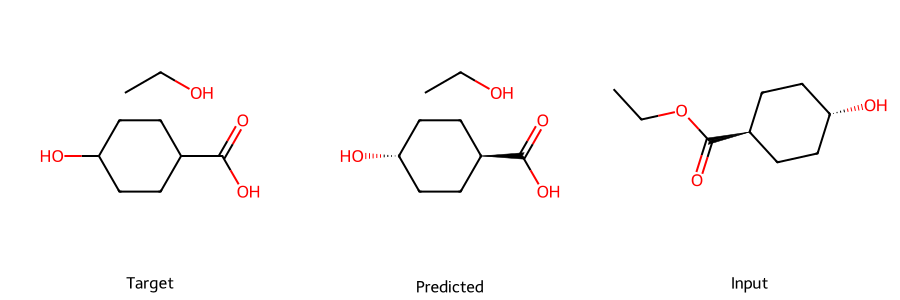

In [59]:
# visualise predicted and target molecules
pick_idx = np.random.choice(aa_idx, 1)[0]
pick_idx = 3836
target_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.target_list[pick_idx])))
predicted_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.predicted_list[pick_idx])))
input_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(eval(df_best.iloc[pick_idx]['input_smiles']))))

print(pick_idx)
Draw.MolsToGridImage([target_mol, predicted_mol, input_mol], molsPerRow=3, subImgSize=(300, 300), legends=['Target', 'Predicted', 'Input'], useSVG=True)

## Partial Accuracy

In [60]:
good_indices = [4849]

4849


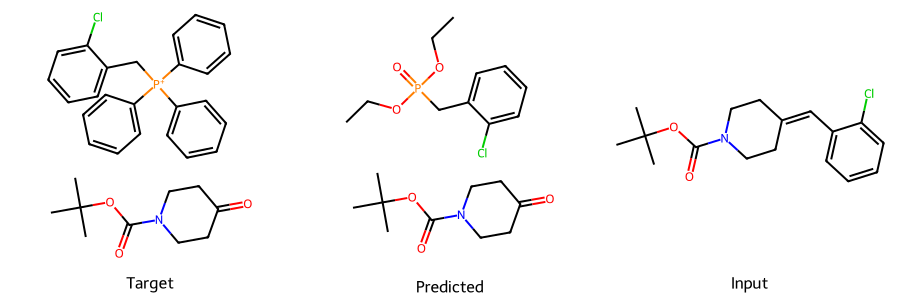

In [61]:
# visualise predicted and target molecules
pick_idx = np.random.choice(pa_idx, 1)[0]
pick_idx = 4849
target_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.target_list[pick_idx])))
predicted_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.predicted_list[pick_idx])))
input_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(eval(df_best.iloc[pick_idx]['input_smiles']))))

print(pick_idx)
Draw.MolsToGridImage([target_mol, predicted_mol, input_mol], molsPerRow=3, subImgSize=(300, 300), legends=['Target', 'Predicted', 'Input'], useSVG=True)

## AA and PA

In [62]:
good_indices = [759]

759


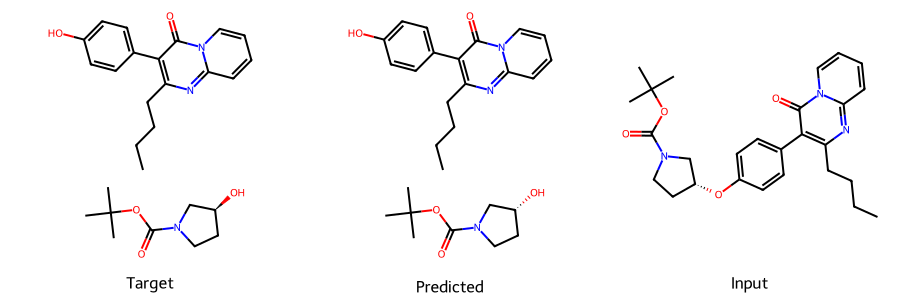

In [63]:
# visualise predicted and target molecules
pick_idx = np.random.choice(aa_pa_idx)
pick_idx = 759
target_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.target_list[pick_idx])))
predicted_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.predicted_list[pick_idx])))
input_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(eval(df_best.iloc[pick_idx]['input_smiles']))))

print(pick_idx)
Draw.MolsToGridImage([target_mol, predicted_mol, input_mol], molsPerRow=3, subImgSize=(300, 300), legends=['Target', 'Predicted', 'Input'], useSVG=True)

## Halogen Correction

In [64]:
good_indices = [1280]

1280


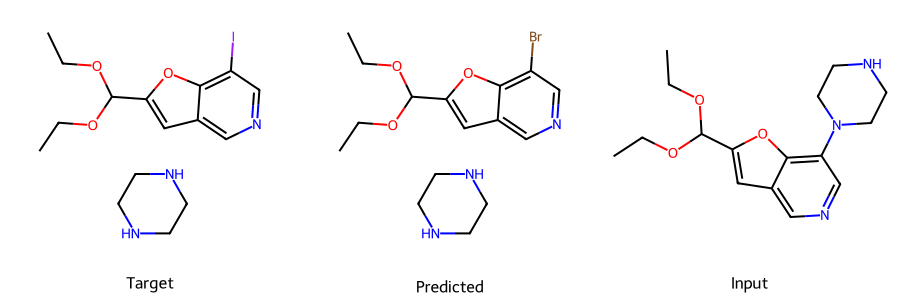

In [65]:
# visualise predicted and target molecules
pick_idx = 1280
target_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.target_list[pick_idx])))
predicted_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.predicted_list[pick_idx])))
input_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(eval(df_best.iloc[pick_idx]['input_smiles']))))

print(pick_idx)
Draw.MolsToGridImage([target_mol, predicted_mol, input_mol], molsPerRow=3, subImgSize=(300, 300), legends=['Target', 'Predicted', 'Input'], useSVG=True)

## Best Examples

In [66]:
good_indices = [431, 1130]

431


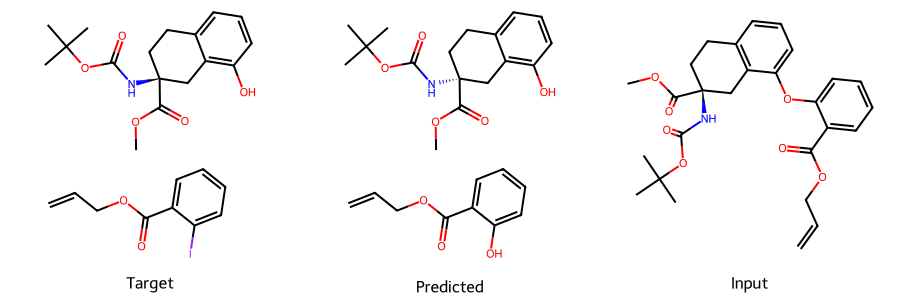

In [67]:
# visualise predicted and target molecules
pick_idx = np.random.choice(everything_idx)
pick_idx = good_indices[0]
target_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.target_list[pick_idx])))
predicted_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.predicted_list[pick_idx])))
input_mol = Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(eval(df_best.iloc[pick_idx]['input_smiles']))))

print(pick_idx)
Draw.MolsToGridImage([target_mol, predicted_mol, input_mol], molsPerRow=3, subImgSize=(300, 300), legends=['Target', 'Predicted', 'Input'], useSVG=True)

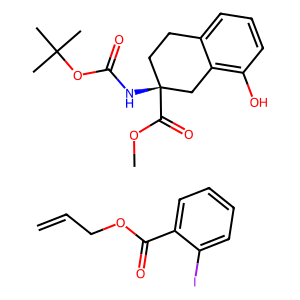

In [68]:
Draw.MolsToGridImage([target_mol], molsPerRow=1, subImgSize=(300, 300), useSVG=True)

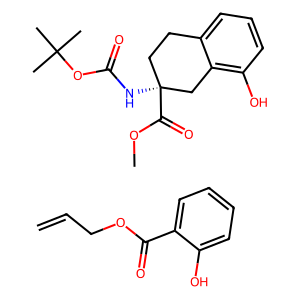

In [69]:
Draw.MolsToGridImage([predicted_mol], molsPerRow=1, subImgSize=(300, 300), useSVG=True)

In [70]:
qa_target_list = [Chem.MolToSmiles(target_mol).split('.')]
qa_predicted_list = [Chem.MolToSmiles(predicted_mol).split('.')]
qa_predicted_list, qa_target_list

([['C=CCOC(=O)c1ccccc1O', 'COC(=O)[C@@]1(NC(=O)OC(C)(C)C)CCc2cccc(O)c2C1']],
 [['C=CCOC(=O)c1ccccc1I', 'COC(=O)[C@]1(NC(=O)OC(C)(C)C)CCc2cccc(O)c2C1']])

In [71]:
qa_metrics = Metrics(qa_target_list, qa_predicted_list, 'Single Example')

Computing metrics with halogen correction True: 100%|██████████| 1/1 [00:00<00:00, 110.90it/s]


In [72]:
qa_metrics.print_metrics([1, 2, 4, 1])

+-----------------------------------------------------------------+
|               Computed Metrics for Single Example               |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.000   |       0.000        |    0.000    |
| Adjusted Accuracy |  0.000   |       0.000        |    0.000    |
|  Partial Accuracy |  0.500   |       0.500        |    0.500    |
| Adjusted Tanimoto |  0.806   |       0.806        |    0.806    |
|     Our Score     |  0.437   |       0.437        |    0.437    |
+-------------------+----------+--------------------+-------------+


In [73]:
rand_idx = np.random.choice(everything_idx)
rand_idx = 3836
target_smiles = Chem.CanonSmiles('.'.join(LLM_best.target_list[rand_idx]))
predicted_smiles = Chem.CanonSmiles('.'.join(LLM_best.predicted_list[rand_idx]))
input_smiles = Chem.CanonSmiles('.'.join(eval(df_best.iloc[rand_idx]['input_smiles'])))
print(f'Index: {rand_idx}')
print(f'Input: {input_smiles}')
print(f'Target: {target_smiles}')
print(f'Predicted: {predicted_smiles}')

Index: 3836
Input: CCOC(=O)[C@H]1CC[C@H](O)CC1
Target: CCO.O=C(O)C1CCC(O)CC1
Predicted: CCO.O=C(O)[C@H]1CC[C@H](O)CC1


# Case Study

In [74]:
df_best = pd.read_csv('results/p3_ablation_res/test_last.csv')

# convert concatenated SMILES strings to lists of SMILES strings
target_list_chem = df_best.apply(lambda x: eval(x['target_smiles']), axis=1).tolist()
predicted_list_chem = df_best.apply(lambda x: eval(x['predicted_smiles']), axis=1).tolist()

LLM_best = Metrics(target_list_chem, predicted_list_chem, 'SynFormer Best')

LLM_best.print_metrics([1, 2, 4, 1])

Computing metrics with halogen correction False:   4%|▎         | 186/5004 [00:00<00:13, 348.77it/s]

Computing metrics with halogen correction True: 100%|██████████| 5004/5004 [00:13<00:00, 370.67it/s]

+-----------------------------------------------------------------+
|               Computed Metrics for SynFormer Best               |
+-------------------+----------+--------------------+-------------+
|       Metric      | Original | Halogen Correction | Final Index |
+-------------------+----------+--------------------+-------------+
|      Accuracy     |  0.532   |       0.558        |    0.545    |
| Adjusted Accuracy |  0.548   |       0.575        |    0.561    |
|  Partial Accuracy |  0.598   |       0.613        |    0.606    |
| Adjusted Tanimoto |  0.784   |       0.784        |    0.784    |
|     Our Score     |  0.598   |       0.613        |    0.606    |
+-------------------+----------+--------------------+-------------+


In [75]:
aa_idx, pa_idx, aa_pa_idx, hc_idx = [], [], [], []
everything_idx = []
for i in range(len(LLM_best.target_list)):
    if LLM_best.accuracy_list[i] == 0:
        if LLM_best.adjusted_accuracy_list[i] > 0:
            aa_idx.append(i)
        if LLM_best.partial_accuracy_list[i] > 0:
            pa_idx.append(i)
        if LLM_best.adjusted_accuracy_list[i] > 0 and LLM_best.partial_accuracy_list[i] > 0:
            aa_pa_idx.append(i)
        if LLM_best.accuracy_list_hc[i] > 0:
            hc_idx.append(i)
        if LLM_best.adjusted_accuracy_list_hc[i] > 0 and LLM_best.partial_accuracy_list_hc[i] > 0:
            everything_idx.append(i)

In [76]:
len(aa_idx), len(pa_idx), len(aa_pa_idx), len(hc_idx), len(everything_idx)

(82, 584, 82, 130, 215)

## Adjusted Accuracy

12 [4726, 3836, 3870, 1999, 666, 4957, 1557, 2207, 21, 4891, 1894, 3870]


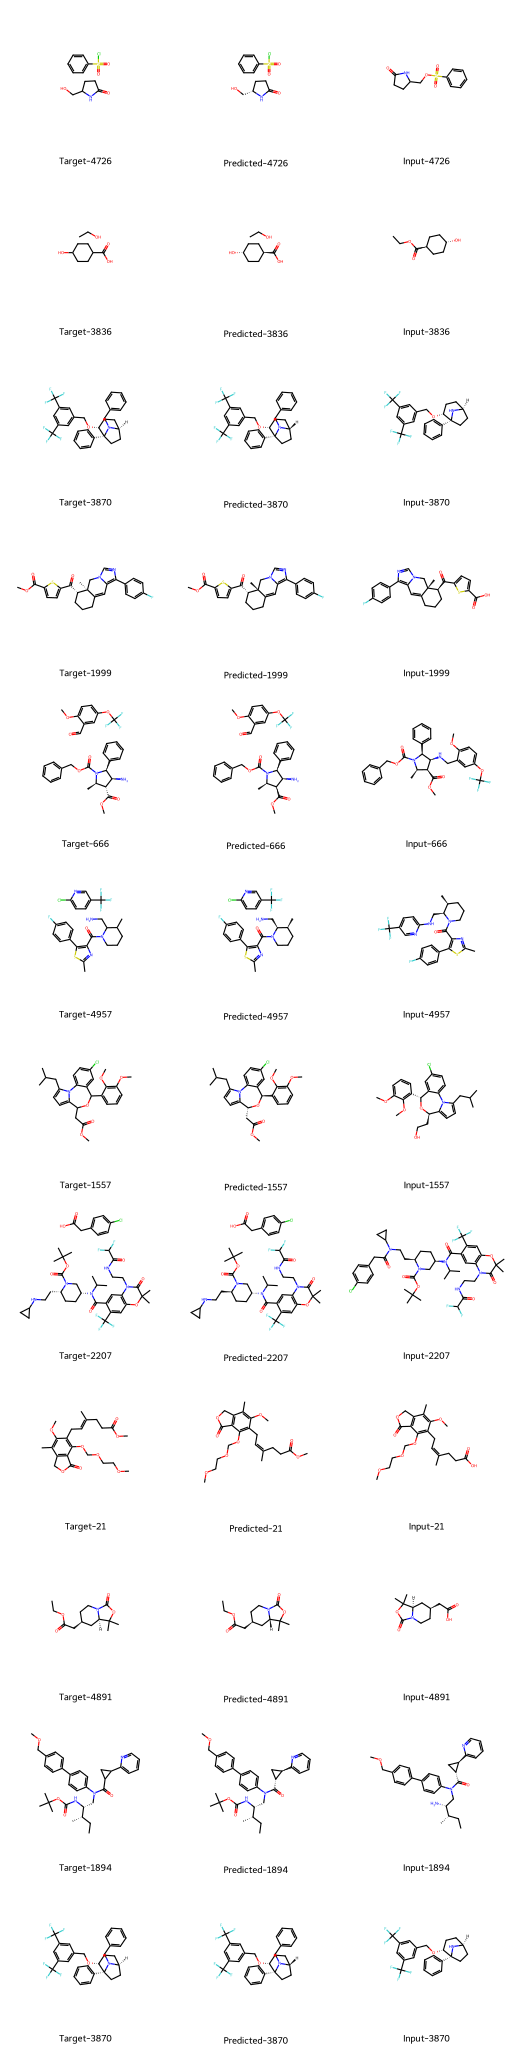

In [77]:
good_indices = [4726, 3836, 3870, 1999, 666, 4957, 1557, 2207, 21, 4891, 1894, 3870]
pick_indices = good_indices

# visualise predicted and target molecules
# pick_indices = np.random.choice(aa_idx, 10)
target_mols = [Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.target_list[pick_idx]))) for pick_idx in pick_indices]
predicted_mols = [Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.predicted_list[pick_idx]))) for pick_idx in pick_indices]
input_mols = [Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(eval(df_best.iloc[pick_idx]['input_smiles'])))) for pick_idx in pick_indices]

grid_mols = [mol for sublist in list(zip(*[target_mols, predicted_mols, input_mols])) for mol in sublist]
legends = [item for sublist in [[f'Target-{i}', f'Predicted-{i}', f'Input-{i}'] for i in pick_indices] for item in sublist]

print(len(pick_indices), pick_indices)
Draw.MolsToGridImage(grid_mols, molsPerRow=3, subImgSize=(300, 300), legends=legends, useSVG=True)

## Partial Accuracy

13 [4849, 56, 3598, 1584, 3776, 3566, 4954, 125, 426, 1780, 3618, 4311, 3936]


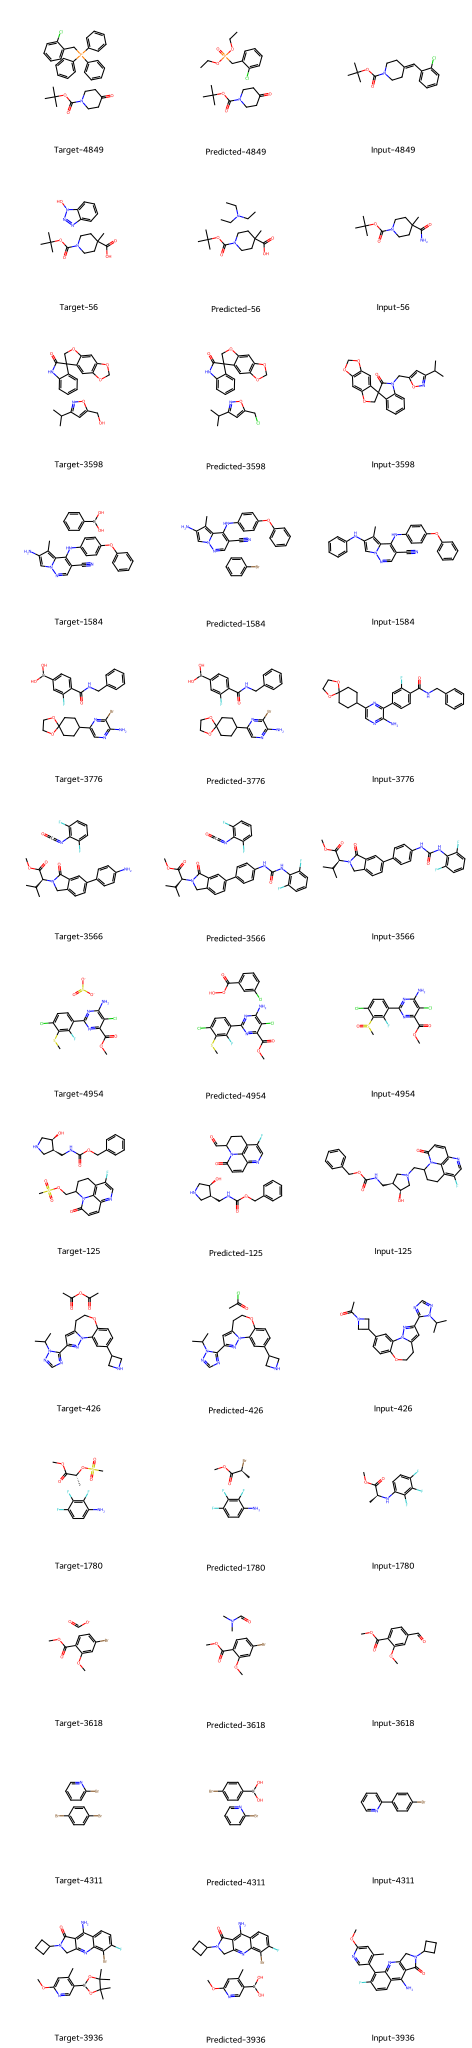

In [78]:
good_indices = [4849, 56, 3598, 1584, 3776, 3566, 4954, 125, 426, 1780, 3618, 4311, 3936]
pick_indices = good_indices

# visualise predicted and target molecules
# pick_indices = np.random.choice(pa_idx, 10)
target_mols = [Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.target_list[pick_idx]))) for pick_idx in pick_indices]
predicted_mols = [Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.predicted_list[pick_idx]))) for pick_idx in pick_indices]
input_mols = [Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(eval(df_best.iloc[pick_idx]['input_smiles'])))) for pick_idx in pick_indices]

grid_mols = [mol for sublist in list(zip(*[target_mols, predicted_mols, input_mols])) for mol in sublist]
legends = [item for sublist in [[f'Target-{i}', f'Predicted-{i}', f'Input-{i}'] for i in pick_indices] for item in sublist]

print(len(pick_indices), pick_indices)
Draw.MolsToGridImage(grid_mols, molsPerRow=3, subImgSize=(300, 300), legends=legends, useSVG=True)

## Halogen Correction

12 [1280, 3474, 4062, 2161, 998, 2236, 2255, 4188, 3430, 671, 147, 1848]


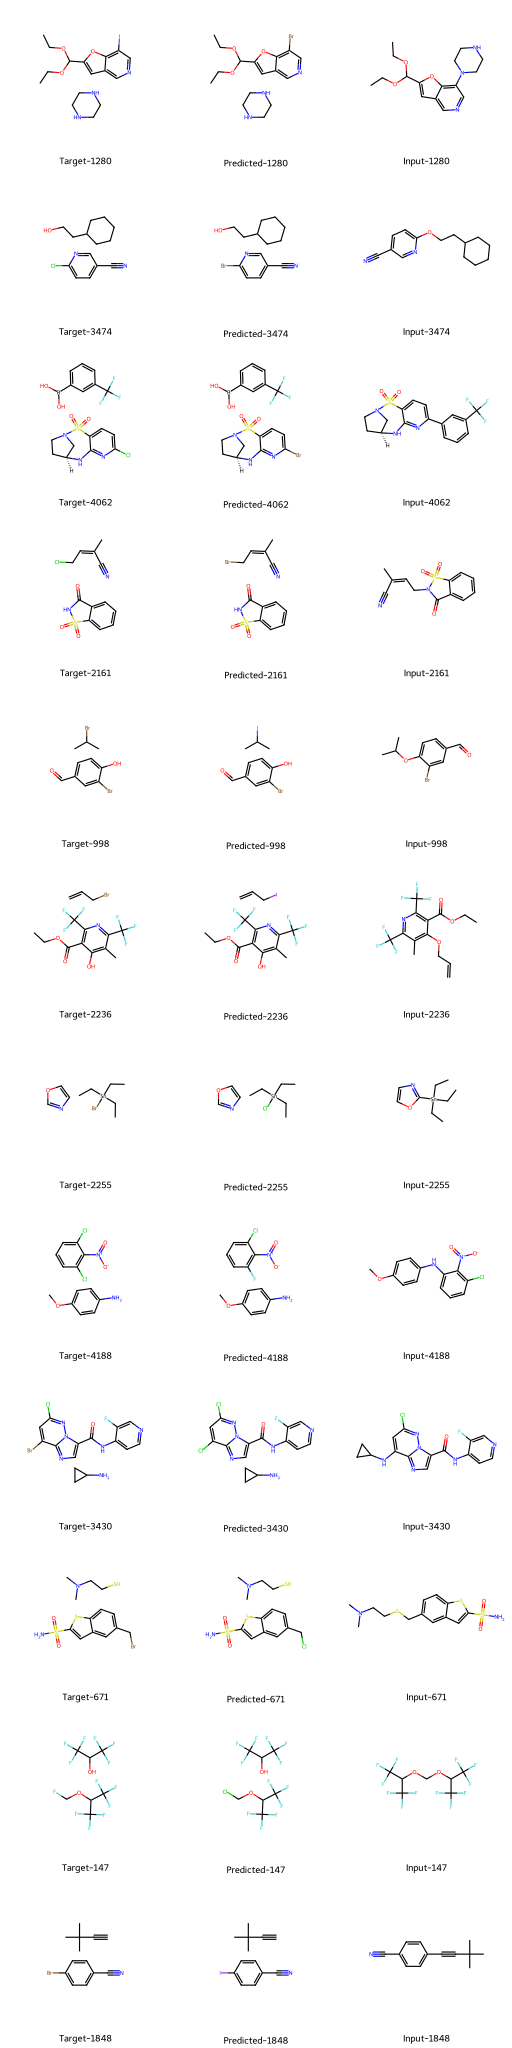

In [79]:
good_indices = [1280, 3474, 4062, 2161, 998, 2236, 2255, 4188, 3430, 671, 147, 1848]
pick_indices = good_indices

# visualise predicted and target molecules
# pick_indices = np.random.choice(hc_idx, 10)
target_mols = [Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.target_list[pick_idx]))) for pick_idx in pick_indices]
predicted_mols = [Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(LLM_best.predicted_list[pick_idx]))) for pick_idx in pick_indices]
input_mols = [Chem.MolFromSmiles(Chem.CanonSmiles('.'.join(eval(df_best.iloc[pick_idx]['input_smiles'])))) for pick_idx in pick_indices]

grid_mols = [mol for sublist in list(zip(*[target_mols, predicted_mols, input_mols])) for mol in sublist]
legends = [item for sublist in [[f'Target-{i}', f'Predicted-{i}', f'Input-{i}'] for i in pick_indices] for item in sublist]

print(len(pick_indices), pick_indices)
Draw.MolsToGridImage(grid_mols, molsPerRow=3, subImgSize=(300, 300), legends=legends, useSVG=True)

# Epoch Ablation

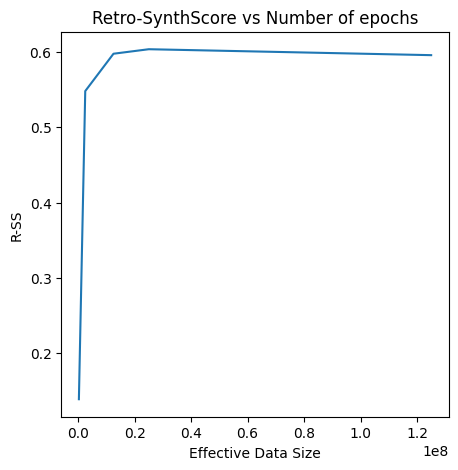

In [80]:
results = [0.1382, 0.5483, 0.5980, 0.6040, 0.5961]
num_epochs = np.array([10, 100, 500, 1000, 5000])
num_epochs = num_epochs * 50000 / 2

plt.figure(figsize=(5, 5))
ax = sns.lineplot(x=num_epochs, y=results)
ax.grid(False)
plt.xlabel('Effective Data Size')
plt.ylabel('R-SS')
plt.title('Retro-SynthScore vs Number of epochs')
plt.show()